In [1]:
from torchvision import transforms, datasets, models
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import time

In [2]:
plt.style.use("ggplot")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = torch.tensor([0.485, 0.456, 0.406]), std = torch.tensor([0.229, 0.224, 0.225]))
    ]),
    
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = torch.tensor([0.485, 0.456, 0.406]), std = torch.tensor([0.229, 0.224, 0.225]))
    ])
}

In [5]:
data_directory = "./Projects/Football Athletes Face Recognition/Data/Cleaned Data"

In [6]:
image_datasets = {dataset: datasets.ImageFolder(root = os.path.join(data_directory, dataset),
                                                transform = data_transforms[dataset])
                  for dataset in ["train", "val"]}

In [7]:
classes = image_datasets["train"].classes

In [8]:
classes

['Cristiano Ronaldo',
 'Erling Haaland',
 'Kylian Mbappe',
 'Lionel Messi',
 'Neymar Jr']

In [9]:
image_dataset_sizes = {dataset: len(image_datasets[dataset]) for dataset in ["train", "val"]}

In [10]:
f"the training dataset contains {image_dataset_sizes["train"]} samples and validation dataset contains {image_dataset_sizes["val"]} samples"

'the training dataset contains 500 samples and validation dataset contains 199 samples'

In [11]:
batch_size = 4

In [12]:
dataloaders = {dataset: torch.utils.data.DataLoader(image_datasets[dataset], batch_size = batch_size, shuffle = True) for dataset in image_datasets}

In [13]:
f"each batch contains {batch_size} samples and there are total {len(dataloaders["train"])} batches in our training data and {len(dataloaders["val"])} batches in our validation data"

'each batch contains 4 samples and there are total 125 batches in our training data and 50 batches in our validation data'

In [14]:
dataiter = iter(dataloaders["train"])

In [15]:
images, labels = next(dataiter)

In [16]:
def imshow(image, labels):
    image = image.numpy().transpose((1, 2, 0))
    image = (image / 2) + 0.5
    plt.imshow(image)
    plt.title([classes[label.item()] for label in labels])
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


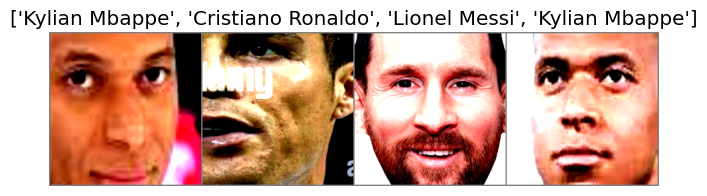

In [17]:
imshow(torchvision.utils.make_grid(images), labels)

In [18]:
model = models.resnet18(weights = "IMAGENET1K_V1")

In [19]:
size_of_last_layer = model.fc.in_features

In [20]:
f"the size of last layer i.e the number of neurons in the resnet 18 pre-trained model is {size_of_last_layer}"

'the size of last layer i.e the number of neurons in the resnet 18 pre-trained model is 512'

In [21]:
model.fc = nn.Linear(size_of_last_layer, len(classes))

In [22]:
model = model.to(device)

In [23]:
epochs = 3
learning_rate = 0.001
n_total_steps = len(dataloaders["train"])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [28]:
starting_time = time.time()

for epoch in range(1, epochs + 1):
    model.train()
    for i, (images_batch, labels_batch) in enumerate(dataloaders["train"]):
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        optimizer.zero_grad()
        outputs = model(images_batch)
        _, predictions = torch.max(outputs, 1)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        if (i % 40 == 0):
            print(f"Epoch # {epoch} / {epochs}, Step # {i} / {n_total_steps}, loss: {loss.item():.3f}")
    scheduler.step()

time_taken = time.time() - starting_time
print(f'Training complete in {time_taken // 60:.0f}m {time_taken % 60:.0f}s')

Epoch # 1 / 3, Step # 0 / 125, loss: 0.834
Epoch # 1 / 3, Step # 40 / 125, loss: 1.867
Epoch # 1 / 3, Step # 80 / 125, loss: 0.820
Epoch # 1 / 3, Step # 120 / 125, loss: 1.012
Epoch # 2 / 3, Step # 0 / 125, loss: 1.139
Epoch # 2 / 3, Step # 40 / 125, loss: 1.031
Epoch # 2 / 3, Step # 80 / 125, loss: 1.398
Epoch # 2 / 3, Step # 120 / 125, loss: 1.832
Epoch # 3 / 3, Step # 0 / 125, loss: 1.291
Epoch # 3 / 3, Step # 40 / 125, loss: 1.400
Epoch # 3 / 3, Step # 80 / 125, loss: 0.575
Epoch # 3 / 3, Step # 120 / 125, loss: 0.861
Training complete in 5m 20s


In [30]:
correct = 0
total = 0
total_predictions = []

with torch.no_grad():
    model.eval()
    for images_batch, labels_batch in dataloaders["val"]:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)

        outputs = model(images_batch)
        _, predictions = torch.max(outputs, 1)

        for prediction in predictions:
            total_predictions.append(prediction.item())

        total += labels_batch.size(0)
        correct += (predictions == labels_batch).sum().item()

accuracy = (correct / total) * 100

In [33]:
f"CNN model's accuracy on test dataset is {accuracy:.3f}"

"CNN model's accuracy on test dataset is 81.407"

In [34]:
torch.save(model.state_dict(), './saved_models/TL_CNN_model_weights.pth')